In [1]:
import pandas as pd

naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_nasbench101'

In [2]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores

search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [3]:
dataset = 'cifar10'
data = dfs[dataset]

In [4]:
from zc_combine.features.conversions import nb101_to_graph

nets = {i: nb101_to_graph(data.loc[i]) for i in data.index}

In [5]:
{len(n[2].edges) for n in nets.values()}

{1, 4, 5, 6, 7, 8, 9}

In [6]:
import json

with open('../zc_combine/configs/nb101_first.json', 'r') as f:
    cfg = json.load(f)

In [7]:
from zc_combine.features.nasbench101 import feature_func_dict
from zc_combine.features.dataset import get_feature_dataset

feature_dataset = get_feature_dataset(nets, cfg, feature_func_dict)
feature_dataset.keys()

dict_keys(['op_count', 'edge_count', 'min_path_len', 'max_op_on_path', 'node_degree', 'num_paths'])

In [8]:
features = ['op_count', 'edge_count', 'min_path_len', 'max_op_on_path', 'node_degree', 'num_paths']
dataset = pd.concat([feature_dataset[f] for f in features], axis=1)
dataset['val_accs'] = data['val_accs']
dataset

,op_count_0,op_count_1,op_count_2,op_count_3,op_count_4,edge_count_,min_path_len_banned_[],min_path_len_banned_[2],min_path_len_banned_[3],min_path_len_banned_[4],...,"node_degree_allowed_[2, 3]_max_in",num_paths_allowed_[],num_paths_allowed_[3],num_paths_allowed_[4],"num_paths_allowed_[3, 4]",num_paths_allowed_[2],"num_paths_allowed_[2, 3]","num_paths_allowed_[2, 4]","num_paths_allowed_[2, 3, 4]",val_accs
idx,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,3,9,2,2,3,2,...,2,0,1,0,3,0,1,1,4,92.417866
1,1,1,0,3,2,8,4,4,7,7,...,1,0,0,0,3,0,0,0,3,89.423078
2,1,1,2,2,1,9,2,2,7,2,...,2,0,1,0,4,0,1,0,4,92.808491
3,1,1,2,2,1,8,3,3,7,4,...,1,0,0,0,1,1,2,1,3,91.055691
4,1,1,2,2,1,9,3,3,7,4,...,2,0,1,0,3,0,1,0,4,89.913863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9776,1,1,2,0,3,9,1,1,1,1,...,1,0,0,3,3,0,0,3,3,93.750000
9777,1,1,0,1,4,7,3,3,7,7,...,1,0,0,1,2,0,0,1,2,90.665066
9778,1,1,2,2,1,9,3,7,3,3,...,2,0,0,0,1,2,3,4,6,89.763623


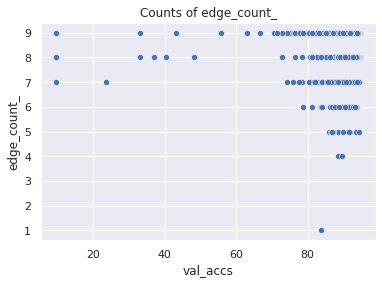

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plot_df = feature_dataset['edge_count'].copy()
plot_df['val_accs'] = data['val_accs']

import os
#os.mkdir('tmp')

for i, c in enumerate(plot_df.columns):
    if i > 5 or c == 'val_accs':
        continue
    plt.figure()
    sns.scatterplot(data=plot_df, x='val_accs', y=c)
    plt.title(f"Counts of {c}")
    #plt.savefig(f'tmp/{c}.png')
    plt.show()

In [10]:
proxy_cols = [c for c in data.columns if c not in ['random', 'rank', 'new_net', 'net']]


def get_dataset(feature_dfs, proxy_df, features, cols):
    feat_dfs = [feature_dfs[f] for f in features]
    prox_df = proxy_df[cols]

    res_data = pd.concat([*feat_dfs, prox_df], axis=1)

    y = proxy_df['val_accs'].loc[res_data.index]
    if 'val_accs' in res_data:
        res_data.drop(columns=['val_accs'], inplace=True)

    return res_data, y

features = ['op_count', 'edge_count', 'min_path_len', 'max_op_on_path', 'node_degree']
full_data, full_y = get_dataset(feature_dataset, data, features, ['flops', 'params'])
print(full_data.shape)
full_data

(9781, 71)


,op_count_0,op_count_1,op_count_2,op_count_3,op_count_4,edge_count_,min_path_len_banned_[],min_path_len_banned_[2],min_path_len_banned_[3],min_path_len_banned_[4],...,"node_degree_allowed_[2, 4]_max_out","node_degree_allowed_[2, 4]_max_in","node_degree_allowed_[2, 3]_in_degree","node_degree_allowed_[2, 3]_out_degree","node_degree_allowed_[2, 3]_avg_in","node_degree_allowed_[2, 3]_avg_out","node_degree_allowed_[2, 3]_max_out","node_degree_allowed_[2, 3]_max_in",flops,params
0,1,1,1,1,3,9,2,2,3,2,...,2,2,2,1,0.428571,0.571429,1,2,1272.747008,8.555530
1,1,1,0,3,2,8,4,4,7,7,...,1,2,0,1,0.428571,0.428571,1,1,870.159360,5.878154
2,1,1,2,2,1,9,2,2,7,2,...,1,2,2,1,0.714286,0.857143,2,2,564.941824,3.729162
3,1,1,2,2,1,8,3,3,7,4,...,1,2,1,2,0.571429,0.714286,2,1,564.941824,3.729162
4,1,1,2,2,1,9,3,3,7,4,...,2,1,1,1,1.000000,0.714286,2,2,496.800768,3.292298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9776,1,1,2,0,3,9,1,1,1,1,...,1,3,0,0,0.285714,0.285714,1,1,645.303552,4.276808
9777,1,1,0,1,4,7,3,3,7,7,...,1,1,0,1,0.142857,0.285714,1,1,5873.832960,39.974282
9778,1,1,2,2,1,9,3,7,3,3,...,1,2,1,2,0.857143,0.857143,2,2,564.941824,3.729162
9779,1,1,2,2,1,9,2,2,3,2,...,1,1,3,1,0.857143,0.714286,1,3,286.625984,1.861666


In [11]:
import numpy as np
from scipy.stats import kendalltau, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


def get_splits(fd, fy, train_size=100, seed=42):
    return train_test_split(fd, fy, random_state=seed, train_size=train_size)

def eval_rf(trx, tex, tryy, tey, n_times=1, random_state=43):
    res = {'score': [], 'tau': [], 'corr': []}
    rfs = []
    for i in range(n_times):
        rf = RandomForestRegressor(random_state=random_state + i, n_estimators=100)
        rf.fit(trx, tryy)
        res['score'].append(rf.score(tex, tey))

        preds = rf.predict(tex)
        res['tau'].append(kendalltau(preds, tey)[0])
        res['corr'].append(spearmanr(preds, tey)[0])
        rfs.append(rf)

    return rfs, res

def print_means(res):
    print(", ".join([f"{k}: {np.mean(v)}" for k, v in res.items()]))

In [12]:
import numpy as np

skip_dis = True

features = ['op_count', 'min_path_len', 'max_op_on_path', 'node_degree']
seed = 44
for ts in [100, 200, 1000]:
    if skip_dis:
        break

    print(f"Train size {ts}")
    for prox in proxy_cols:
        for include_fp in [True, False]:
            if prox in ['flops', 'params']:
                continue
            print(prox, "" if include_fp else " no fp")

            plist = ['flops', 'params', prox] if include_fp else [prox]
            fd, fy = get_dataset(feature_dataset, data, features, plist)
            data_splits = get_splits(fd, fy, train_size=ts, seed=seed)

            _, res = eval_rf(*data_splits, n_times=5)
            print_means(res)
            print()

In [49]:
ts = 100
#seed = 45
seed = 40

all_proxies = False
prox_to_include = []
prox_to_include = ['fisher']
with_features = True

features = ['op_count',  'min_path_len', 'max_op_on_path', 'node_degree', 'num_paths']
feat_list = features if with_features else []

# proxies to add to data
def_proxlist = ['params', 'flops'] if prox_to_include is None else ['params', 'flops', *prox_to_include]
prox_list = proxy_cols if all_proxies else def_proxlist

fd, fy = get_dataset(feature_dataset, data, feat_list, prox_list)
train_X, test_X, train_y, test_y = get_splits(fd, fy, train_size=ts, seed=seed)

rfs, res = eval_rf(train_X, test_X, train_y, test_y, n_times=5)
print_means(res)
rf_fitted = rfs[0]
preds = rf_fitted.predict(fd)
preds

score: 0.11807803330810034, tau: 0.654923382874288, corr: 0.8392678947605325


array([92.50000018, 89.21985221, 90.99519193, ..., 90.58924335,
       90.94230783, 92.06270027])

In [50]:
trainpreds = rf_fitted.predict(train_X)

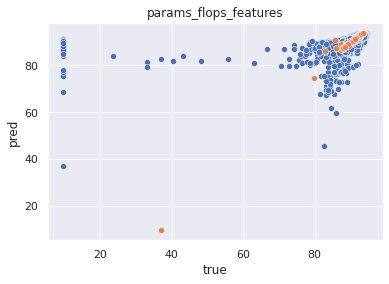

In [51]:
sns.scatterplot(data=pd.DataFrame({'pred': preds, 'true': fy}), x='true', y='pred')
sns.scatterplot(data=pd.DataFrame({'pred': trainpreds, 'true': train_y}), x='pred', y='true')
#plt.ylim(70, 95)

#plt.xlim(65, 95)
#plt.ylim(65, 95)

plt_name = f"{'all_proxies' if all_proxies else 'params_flops'}_{'features' if with_features else 'no_features'}"
plt.title(plt_name)
#plt.savefig(f"tmp/{plt_name}.png")
plt.show()

In [41]:
imps = rf_fitted.feature_importances_

pd.DataFrame({"importance": imps, "feat": fd.columns}).sort_values('importance', ascending=False)

,importance,feat
76,0.206001,params
77,0.176495,flops
5,0.056568,min_path_len_banned_[]
6,0.051450,min_path_len_banned_[2]
78,0.050647,fisher
...,...,...
22,0.000000,node_degree_allowed_[]_avg_in
21,0.000000,node_degree_allowed_[]_out_degree
1,0.000000,op_count_1
20,0.000000,node_degree_allowed_[]_in_degree


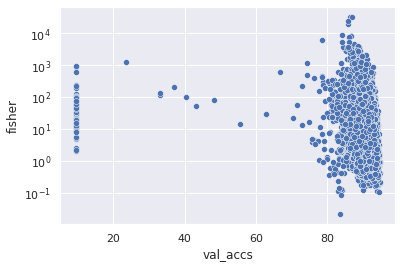

In [246]:
sns.scatterplot(data=data, x='val_accs', y='fisher')
plt.yscale('log')
plt.show()

In [57]:
adj_acc = (data['val_accs'] - data['val_accs'].mean())
adj_acc[adj_acc < -10] = -12
adj_acc = (adj_acc + np.abs(adj_acc)) / 2
adj_acc = adj_acc // 1
adj_acc.unique()

array([2., 0., 3., 1., 4.])

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE()
tsne_data = tsne.fit_transform(fd)

/home/gabi/.env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gabi/.env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


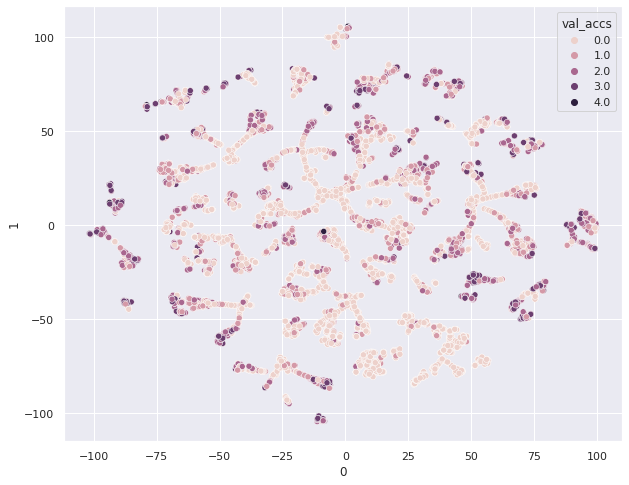

In [59]:
plot_dd = pd.DataFrame(tsne_data)
plot_dd['val_accs'] = adj_acc


plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs')
#plt.xlim(-2000, 5000)
plt.show()

In [61]:
from sklearn.decomposition import PCA

pca_data = fd#data[proxy_cols]
pca = PCA(n_components=2)
pca_data = pca.fit_transform(pca_data)
pca_data

array([[  92.38950574,  -72.37572629],
       [-285.80464836,  236.29062811],
       [-609.69343355,   25.83435388],
       ...,
       [-612.98712957,  -13.57477548],
       [-890.54169124,    7.24456938],
       [  -7.34587946,  -57.86322149]])

In [62]:
pca_tr = pca.transform(train_X)
pca_te = pca.transform(test_X)

In [63]:
rfpca = RandomForestRegressor()
rfpca.fit(pca_tr, train_y)
pred_pca = rfpca.predict(pca_te)
rfpca.score(pca_te, test_y)

0.05214338020073972

In [64]:
kendalltau(test_y, pred_pca)[0], spearmanr(test_y, pred_pca)[0]

(0.3898435017061727, 0.5483016713523494)

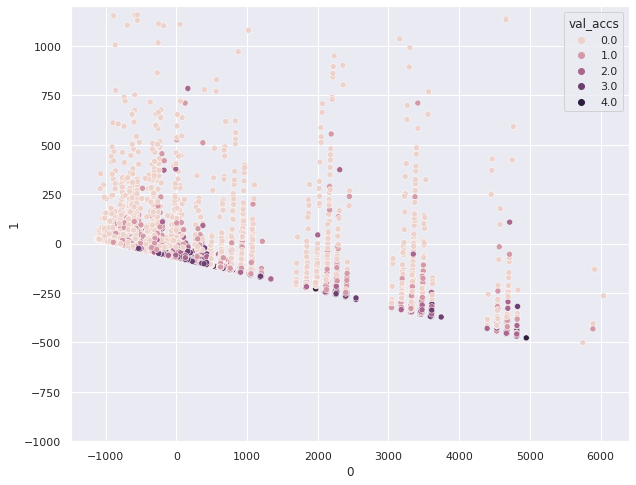

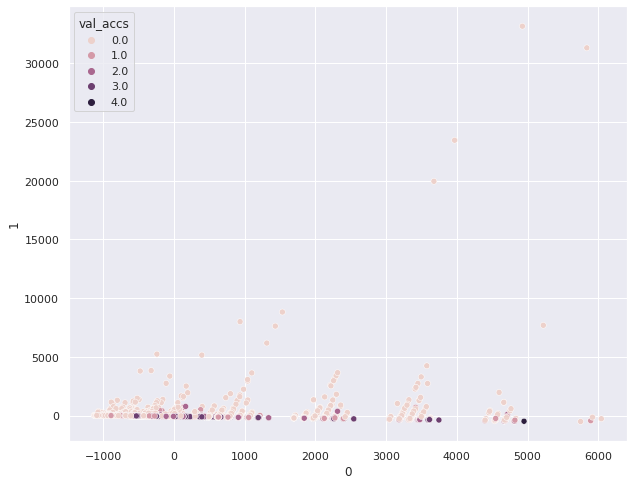

In [65]:
plot_dd = pd.DataFrame(pca_data)
plot_dd['val_accs'] = adj_acc

plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs')
plt.ylim(-1000, 1200)
plt.show()

plt.figure(figsize=(10,8))
sns.scatterplot(data=plot_dd, x=0, y=1, hue='val_accs')
#plt.xlim(-2000, 5000)
plt.show()

In [124]:
# IDEA ... sample different nets based on clustering (max distance between nets...)